In [1]:
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt
from mlx.data import datasets

In [4]:
cifar100_train = datasets.load_cifar100(train=True)

cifar100_example = next(cifar100_train.batch(1).to_stream())
original_input_shape = cifar100_example["image"].shape
X = mx.array(cifar100_example["image"].astype("float32"))

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_dims, stride):
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_dims, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm(num_features=out_dims)
        self.conv2 = nn.Conv2d(in_channels=out_dims, out_channels=out_dims, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm(num_features=out_dims)
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_dims, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm(num_features=out_dims)
            )
    def __call__(self, x):
        y = nn.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += self.shortcut(x)
        return y


In [6]:
class Net(nn.Module):
    def __init__(self, in_channels, num_blocks):
        self.in_planes = 16
        self.conv1 = nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=self.in_planes, stride=2, padding=1)
        self.res1 = self._make_layer(16, num_blocks[0], stride=1)
        self.res2 = self._make_layer(32, num_blocks[1], stride=2)
        self.res3 = self._make_layer(64, num_blocks[1], stride=2)
    def _make_layer(self, channels, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            layers.append(ResidualBlock(self.in_planes, channels, stride=stride if i == 0 else 1))
            self.in_planes = channels
        return nn.Sequential(*layers)
    def __call__(self, x):
        y = self.conv1(x)
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        return y
        

In [7]:
net = Net(in_channels=X.shape[-1], num_blocks=[3, 3, 3])

In [8]:
y = net(X)
y.shape

(1, 4, 4, 64)

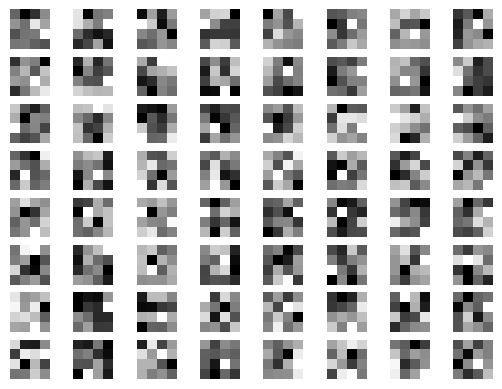

In [11]:
n_cols = 8
n_rows = y.shape[-1] // n_cols
for i in range(y.shape[-1]):
    fig = plt.subplot(n_rows, n_cols, i + 1)
    fig.imshow(y[0, :, :, i], cmap="gray")
    fig.axis("off")

plt.show()

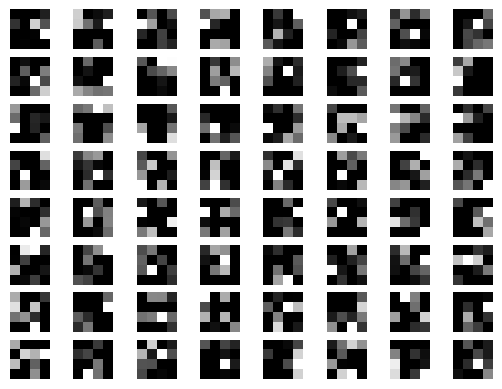

In [12]:
y = nn.relu(y)
n_cols = 8
n_rows = y.shape[-1] // n_cols
for i in range(y.shape[-1]):
    fig = plt.subplot(n_rows, n_cols, i + 1)
    fig.imshow(y[0, :, :, i], cmap="gray")
    fig.axis("off")

plt.show()